# Baccarelli Lab AWS RONIN tutorial_4
This is the tutorial#4: 
- HPC demo for large GESTE shotgun metagenome data

### by Yike Shen, 06/04/2021

Before start, make sure you have installed and launched following:

- Tutorial1: Created autoscale cluster that meet your own need
- Tutorial1: launched RONIN Link terminal
- Tutorial1: launched Gangalia monitoring app (optional)
- Tutorial2: Installed AWS CLI (RONIN and your local computer)
- Tutorial2: Transferred your working data to RONIN
- Tutorial3: Installed conda


Notes:
    <br>
Attention: install conda in root drive, install all dependencies, package cluster, and launch a new cluster to submit jobs
<br>
Attention: you must launch autoscale clusters to run shotgun jobs



In [ ]:
#Step1: copy data from AWS S3 to RONIN
aws s3 cp s3://yikeshen/GESTE_2020_shotgunRaw/1004_S14_L001_R1_001.fastq.gz /shared/shotguntest/rawfastq
#same for other 4 files

In [ ]:
#Step2: cat raw fastq from two lanes into one, both forward and reverse reads
#Note, for simplicity, this demo does not include any unix loop on batch processing samples. 
#Interested individuals can contact me directly on how to batch processing reads.
mkdir step1catreads
cat rawfastq/1004_S14_L001_R1_001.fastq.gz rawfastq/1004_S14_L002_R1_001.fastq.gz >step1catreads/1004_R1.fastq.gz
cat rawfastq/1004_S14_L001_R2_001.fastq.gz rawfastq/1004_S14_L002_R2_001.fastq.gz >step1catreads/1004_R2.fastq.gz

In [ ]:
#Step3: fastqc raw sequence, read the fastqc report, decide what to do (trim what adapter/head and tail reads)
#install fastqc
#https://www.bioinformatics.babraham.ac.uk/projects/fastqc/
wget https://www.bioinformatics.babraham.ac.uk/projects/fastqc/fastqc_v0.11.9.zip
sudo apt install fastqc
#runfastqc
#export to the path, no need in RONIN, may need in other machines
#export PATH=$PATH://home/ubuntu/shotguntest/fastQC/
fastqc -o fastQCresults/ -t 28 step1catreads/1004_R1.fastq.gz

#Now you may want to see fastqc html results
### Please see step5 in tutorial 1 on how to open html file in ubuntu desktop

In [ ]:
#Step4: Run Trimmomatic to trim adapters and head/tail reads

#Find preinstalled package in RONIN machine
spack list
#Install Trimmomatic
spack install trimmomatic
spack find --paths

#run trimmomatic
#Depending on job length, you can submit multiple jobs, optimize your compute time and sample number.
#vi create batch files, Start your slurm jobs with 3 lines below
#!/bin/bash
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=2

java -jar /apps/spack/opt/spack/linux-ubuntu18.04-skylake_avx512/gcc-7.5.0/trimmomatic-0.39-z726olknuyo7gpp4dui2g2bby7ussbx3/bin/trimmomatic-0.39.jar\
PE -phred33 1004_R1.fastq.gz 1004_R2.fastq.gz\
../QC_data/1004_R1.fastq.gz ../QC_data/1004.qcup_R1.fastq.gz\
../QC_data/1004_R2.fastq.gz ../QC_data/1004.qcup_R2.fastq.gz\
ILLUMINACLIP:/apps/spack/opt/spack/linux-ubuntu18.04-skylake_avx512/gcc-7.5.0/trimmomatic-0.39-z726olknuyo7gpp4dui2g2bby7ussbx3/share/adapters/NexteraPE-PE.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36


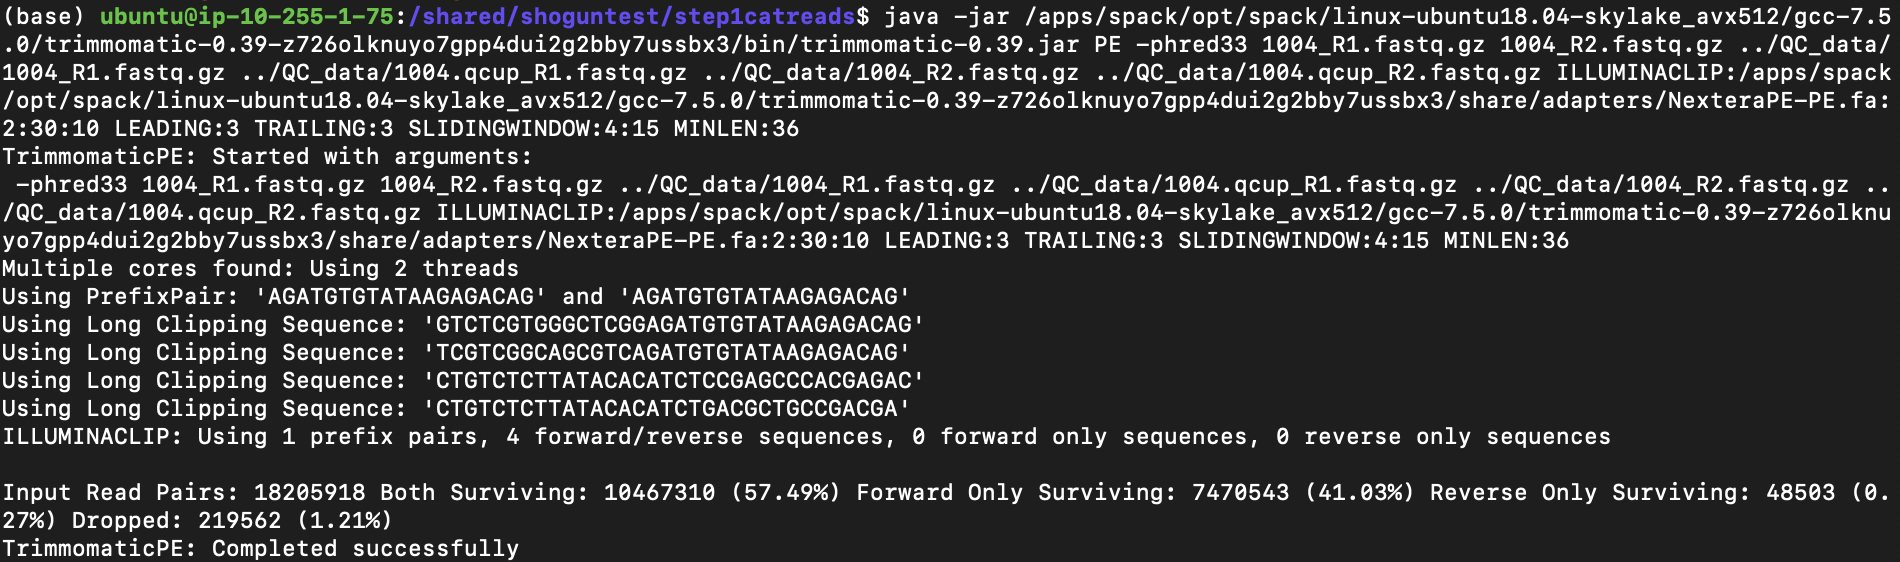

In [ ]:
#Step5: Remove human reads

#### Option 1: Conda
####Conda always come first with bioinformatics

#create conda environment for shotgun
#/home/ubuntu/anaconda3/envs/shotgun
conda create --name shotgun
#compute on your conda environment
conda activate shotgun
#install Bowtie alignment tool
conda install -c bioconda bowtie2


#### Option2: spack
####Spack comes second
#check if bowtie2 is in spack
spack list bowtie2
spack load bowtie 
spack install bowtie2
####

#download reference genome
wget https://genome-idx.s3.amazonaws.com/bt/GRCh38_noalt_as.zip
#unzip human reference genome
unzip GRCh38_noalt_as.zip

#Slurm job example below for bowtie2
#attention: you need to submit a slurm job for this, each sample runs approximately 3 hours

In [ ]:
#!/bin/bash
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1

export OMP_NUM_THREADS=2

conda init bash
export CONDA3PATH=/home/ubuntu/anaconda3/
conda activate shotgun

cd /shared/shotguntest/GRCh38_noalt_as

export PATH=$PATH:/home/ubuntu/anaconda3/envs/shotgun/bin

bowtie2 -x GRCh38_noalt_as\
-1 ../QC_data/1004_R1.fastq.gz -2 ../QC_data/1004_R2.fastq.gz\
-S ../hostremovedfastq/1004.sam --threads 28 --un-conc-gz\
../hostremovedfastq/1004.dehost.fq.gz

scontrol show job $SLURM_JOB_ID


In [ ]:
#Step6:humann profiling

#activate conda environment
conda activate shotgun

#install humann3 and metaphlan.
conda config --add channels defaults
conda config --add channels bioconda
conda config --add channels conda-forge
conda config --add channels biobakery
conda install -c biobakery humann
conda install -c bioconda python=3.7 metaphlan

export PATH=$PATH:/home/ubuntu/anaconda3/envs/shotgun/bin/humann
#test successful
humann_test


#practice not
humann --input demo.fastq --output humann_results

##This is too large, stop here. 
humann_databases --download chocophlan full humann_results/


Now you have some basic dependencies installed in conda.
<br>
Follow the steps below before batch submitting your jobs
- Package your cluster (tutorial_1)
- Relaunch a new cluster in order to have root conda called
- Check if files has been transferred, if not transfer files to the new cluster (tutorial_2)
- Now you can submit jobs (see one demo example below). Replace humann_test with real life code from Humann3 tutorial

<br>
Note: Because compute node is different than master node, a image has to be created for slurm jobs to call. RONIN is improving on this, in the future, you maybe able to install conda in home /shared directory, so you don't need to do the steps above!

In [ ]:
#!/bin/bash
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=2

export OMP_NUM_THREADS=2

cd /shared/shotguntest

conda activate shotgun

export PATH=$PATH:/home/ubuntu/anaconda3/envs/shotgun/bin/humann

humann_test

In [ ]:
#miscellaneous 
#find path
echo $PATH

#check if the cluster started
sinfo